In [240]:
n=10000
m=10
p=3 #Barabasi-Albert parameter
init_Theta=0.05#0.06
N=10 #number of time steps
r=0 #0.3 #szansa aktywacji przy negatywnej korelacji
prob=0.20 #prawd. aktywności użytkownika w danej epidemii (do generaowania macierzy)
a=0.15#0.04 # parameter kształtu powr-law

In [241]:
%matplotlib inline

import matplotlib
import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import scipy.sparse as sparse
import asizeof
from collections import defaultdict
G=nx.barabasi_albert_graph(n, p)
print('1.Undirected graph done!')
G=G.to_directed()
print('2.Directed graph done!')
for u,v in tqdm(G.edges()):
    G[u][v]['weight']=1.0#np.random.uniform(0,1)
print('3.Wieghts assigned!')
for i in tqdm(range(n)):
    in_degree=G.in_degree(i,weight='weight')
    for u,v in G.in_edges(i):
        #print(u,v,G[u][v]['weight'],G[u][v]['weight'] / in_degree, in_degree)
        G[u][v]['weight']/=in_degree
print('4.Wieghts normalized!')
W=nx.adjacency_matrix(G,weight='weight')
print('4.Adjacency (sparse) matrix created!')

1.Undirected graph done!
2.Directed graph done!


HBox(children=(IntProgress(value=0, max=59982), HTML(value='')))


3.Wieghts assigned!


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


4.Wieghts normalized!
4.Adjacency (sparse) matrix created!


In [242]:
C = np.random.random((m, m))
C=C*2-1
C *= np.tri(*C.shape,k=-1)
C=C+np.transpose(C)+np.eye(m)
print(C.min(),C.max(),C.mean(),np.median(C))
print("Correlation matrix done!")

-0.960692492743 1.0 0.205043315863 0.302298647108
Correlation matrix done!


In [243]:
C[3][5]

-0.82269349017344617

In [244]:
indykatory=[]
frakcje=[]
import scipy.stats as stats
frac_inf=np.ceil(stats.powerlaw.rvs(a,size=(m))*n).astype(int)
I=np.full((n, m), False, dtype=bool)
for i in tqdm(range(m)):
    I[np.ix_(stats.randint.rvs(0, n-1, size=frac_inf[i]),[i])]=True
indykatory.append(I)
frakcje.append(np.vstack((range(m),np.sum(I,axis=0)/n)))
I=I.copy()
print("Initial state assigned!")

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Initial state assigned!


In [245]:
Theta=np.full((n,m), init_Theta)
print("Initial Theta assigned!")

Initial Theta assigned!


In [246]:
Y=np.full((n,1),0)
print("Activation counter initiated!")

Activation counter initiated!


In [247]:
dep_3_5=dict()
for i in range(0,101):
    dep_3_5[i]=0
dep_3_5[0]

0

In [248]:
#dep_23_45=defaultdict(lambda: 0)
for l in tqdm(range(N)):    
    U=W.transpose().dot(I)
    F=U.dot(C)/m
    #print(F.min(),F.max(),F.mean(),l)
    temp=np.greater_equal(F, Theta) #porównanie funkcji aktywacji z progiem
    for i in np.unique(np.where(temp[:,:]==True)[0]): #interacja po użytkownikach, którzy mają przekroczony próg
        temp1=np.where(temp[i,:]==True)[0] #tagi, w których dla użytkownika i przekroczony był próg
        #print(i,temp1.shape,l)
        temp2=np.where(I[i][temp1]==True)[0] #tagi juz aktywne
        temp1=np.setdiff1d(temp1,temp2) #usuniecie juz aktywnych tagow
        # CZY NIE TRZEBA OSOBNO OBSLUZYC PUSTYCH temp1?
        if not np.any(C[temp1[:, None],temp1]<0): #sprawdzenie, czy kandydaci do aktywacji nie są negatywnie skorelowani
            if np.any(np.isin(temp1,5)):
                dep_3_5[int(U[i][3]*100)]+=1
                #print(int(U[i][3]*100))
            I[i][temp1]=1 #aktywacja uzytkownika i w tagach z listy temp1
            Y[i]+=1 #zwiekszenie licznika aktywacji uzytkownika i
            Theta[i]=1-(1-init_Theta)**Y[i] #aktualizacja thety
        else:
            if np.random.rand()<r: #aktywacji pomimo negatywnej korelacji z pr. r
                I[i][temp1]=True
                Y[i]+=1
                Theta[i]=1-(1-init_Theta)**Y[i]
    indykatory.append(I)
    frakcje.append(np.vstack((range(m),np.sum(I,axis=0)/n)))
    I=I.copy()
del temp

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

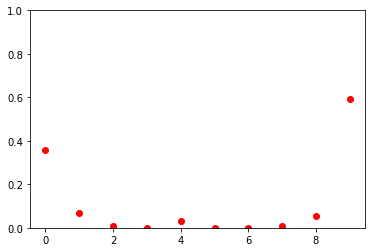

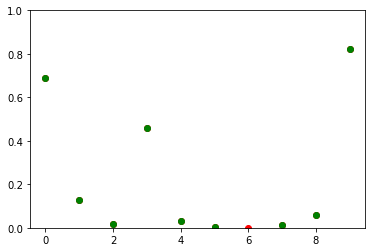

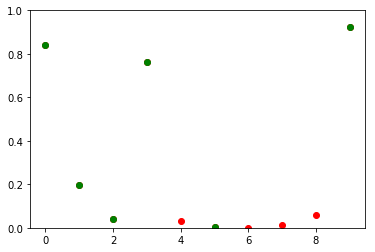

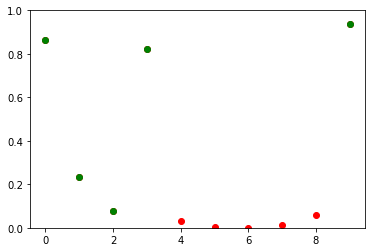

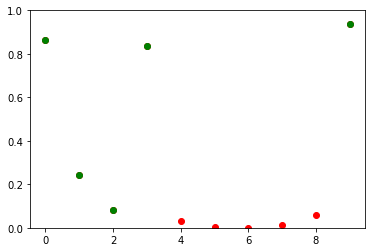

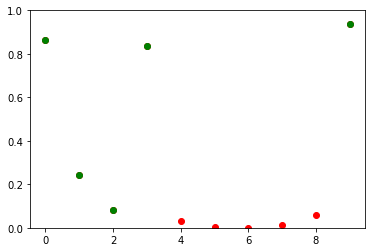

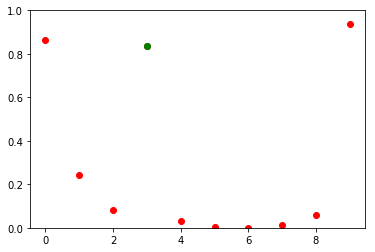

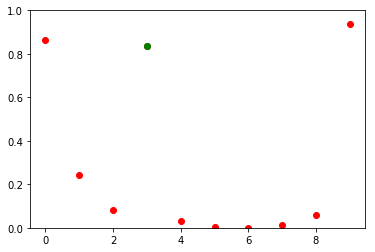

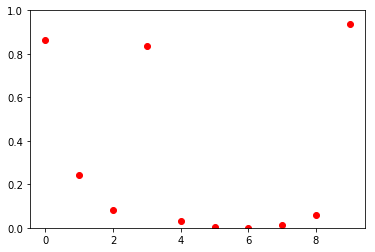

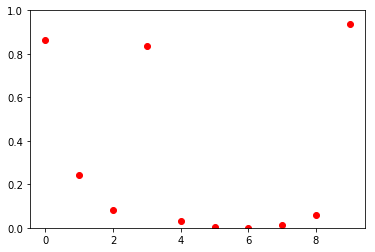

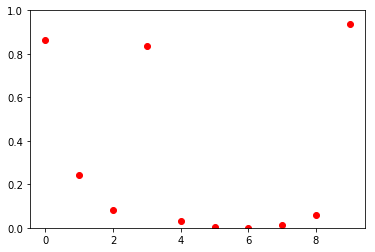

In [249]:
for i in range(N+1):
    plt.plot(frakcje[i][1], 'ro')
    axes = plt.gca()
    axes.set_ylim([0,1])
    if i>0:
        wzrost=frakcje[i][np.ix_([0,1],np.where(frakcje[i]>frakcje[i-1])[1])]
        plt.plot(wzrost[0],wzrost[1], 'go')
    plt.show()

In [250]:
for i in range(N):
    if np.array_equal(indykatory[i],indykatory[i+1])==True:
        print(i)

7
8
9


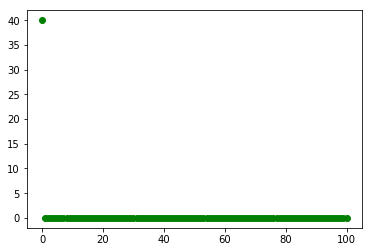

In [251]:
lists = sorted(dep_3_5.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y, 'go')
plt.show()